In [1]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt

Load Data

In [2]:
tv = TvDatafeed()

df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=4500)

you are using nologin method, data you access may be limited


Unit Root Test

In [3]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['close'], autolag='BIC')
print(result[1])

0.41713590639351056


In [4]:
returns = np.log(df['close']).diff().dropna() #1st difference

result = adfuller(returns, autolag='BIC')
print(result[4])
print(result[0])
print(result[1])

{'1%': -3.431804978127318, '5%': -2.862182927172891, '10%': -2.567112233631009}
-45.81268627294295
0.0


Train-Test Split

In [5]:
returns_train, returns_test= returns[:-120], returns[-120:]

Methods tried

In [6]:
from arch import arch_model
garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off')
print(garch_model_fit.summary)

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13484.9
Distribution:                  Normal   AIC:                          -26961.8
Method:            Maximum Likelihood   BIC:                          -26936.3
                                        No. Observations:                 4379
Date:                Wed, Apr 24 2024   Df Residuals:                     4378
Time:                        16:35:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.3810

c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off')
print(arch_model_fit.summary)

<bound method ARCHModelResult.summary of                       Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                13025.4
Distribution:                  Normal   AIC:                          -26044.7
Method:            Maximum Likelihood   BIC:                          -26025.6
                                        No. Observations:                 4379
Date:                Wed, Apr 24 2024   Df Residuals:                     4378
Time:                        16:35:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.4

c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [8]:
gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off')
print(gjr_garch_model_fit.summary)

<bound method ARCHModelResult.summary of                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                13516.8
Distribution:                  Normal   AIC:                          -27023.6
Method:            Maximum Likelihood   BIC:                          -26991.7
                                        No. Observations:                 4379
Date:                Wed, Apr 24 2024   Df Residuals:                     4378
Time:                        16:35:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.1

c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [9]:
harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off')
print(harch_model_fit.summary)

<bound method ARCHModelResult.summary of                      Constant Mean - HARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      HARCH   Log-Likelihood:                10731.2
Distribution:                  Normal   AIC:                          -21456.4
Method:            Maximum Likelihood   BIC:                          -21437.3
                                        No. Observations:                 4379
Date:                Wed, Apr 24 2024   Df Residuals:                     4378
Time:                        16:35:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1

c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Realized Volatility

In [10]:
realized_volatility = np.log(df['high']/df['low'])
realized_volatility = realized_volatility.iloc[1:]
realized_volatility = realized_volatility
realized_volatility_train, realized_volatility_test= realized_volatility[:-120], realized_volatility[-120:]

Fixed-Window Forecast

In [11]:
garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic')
arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic')
gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic')
harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic')

Estimation Result

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

garch_mse = mean_squared_error(realized_volatility_test,np.sqrt(garch_forecast.variance.values[-1,:]))
arch_mse = mean_squared_error(realized_volatility_test,np.sqrt(arch_forecast.variance.values[-1,:]))
gjr_garch_mse = mean_squared_error(realized_volatility_test,np.sqrt(gjr_garch_forecast.variance.values[-1,:]))
harch_mse = mean_squared_error(realized_volatility_test,np.sqrt(harch_forecast.variance.values[-1,:]))
mse = [garch_mse,arch_mse,gjr_garch_mse,harch_mse]

garch_rmse = np.sqrt(garch_mse)
arch_rmse = np.sqrt(arch_mse)
gjr_garch_rmse = np.sqrt(gjr_garch_mse)
harch_rmse = np.sqrt(harch_mse)
rmse = [garch_rmse,arch_rmse,gjr_garch_rmse,harch_rmse]

garch_mae = mean_absolute_error(realized_volatility_test,np.sqrt(garch_forecast.variance.values[-1,:]))
arch_mae = mean_absolute_error(realized_volatility_test,np.sqrt(arch_forecast.variance.values[-1,:]))
gjr_garch_mae = mean_absolute_error(realized_volatility_test,np.sqrt(gjr_garch_forecast.variance.values[-1,:]))
harch_mae = mean_absolute_error(realized_volatility_test,np.sqrt(harch_forecast.variance.values[-1,:]))
mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]

garch_mape = mean_absolute_percentage_error(realized_volatility_test,np.sqrt(garch_forecast.variance.values[-1,:]))
arch_mape = mean_absolute_percentage_error(realized_volatility_test,np.sqrt(arch_forecast.variance.values[-1,:]))
gjr_garch_mape = mean_absolute_percentage_error(realized_volatility_test,np.sqrt(gjr_garch_forecast.variance.values[-1,:]))
harch_mape = mean_absolute_percentage_error(realized_volatility_test,np.sqrt(harch_forecast.variance.values[-1,:]))
mape = [garch_mape,arch_mape,gjr_garch_mape,harch_mape]

In [13]:
model = ['GARCH','ARCH','GJR','HARCH']
conclu = pd.DataFrame(model, columns=['Model'])
conclu['MSE'] = mse
conclu['RMSE'] = rmse
conclu['MAE'] = mae
conclu['MAPE'] = mape
conclu

,Model,MSE,RMSE,MAE,MAPE
0,GARCH,0.000018,0.004283,0.003667,0.437463
1,ARCH,0.000020,0.004445,0.003848,0.463187
2,GJR,0.000021,0.004584,0.004013,0.480025
3,HARCH,0.000024,0.004864,0.004304,0.506814


Fit entire dataset with the best model

In [14]:
forecast_model_fit = arch_model(returns,vol="Garch",p=1,q=1).fit(disp='off')
print(forecast_model_fit.summary)

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13896.3
Distribution:                  Normal   AIC:                          -27784.5
Method:            Maximum Likelihood   BIC:                          -27758.9
                                        No. Observations:                 4499
Date:                Wed, Apr 24 2024   Df Residuals:                     4498
Time:                        16:35:39   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.2113

c:\Users\Inv_edg\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001764. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


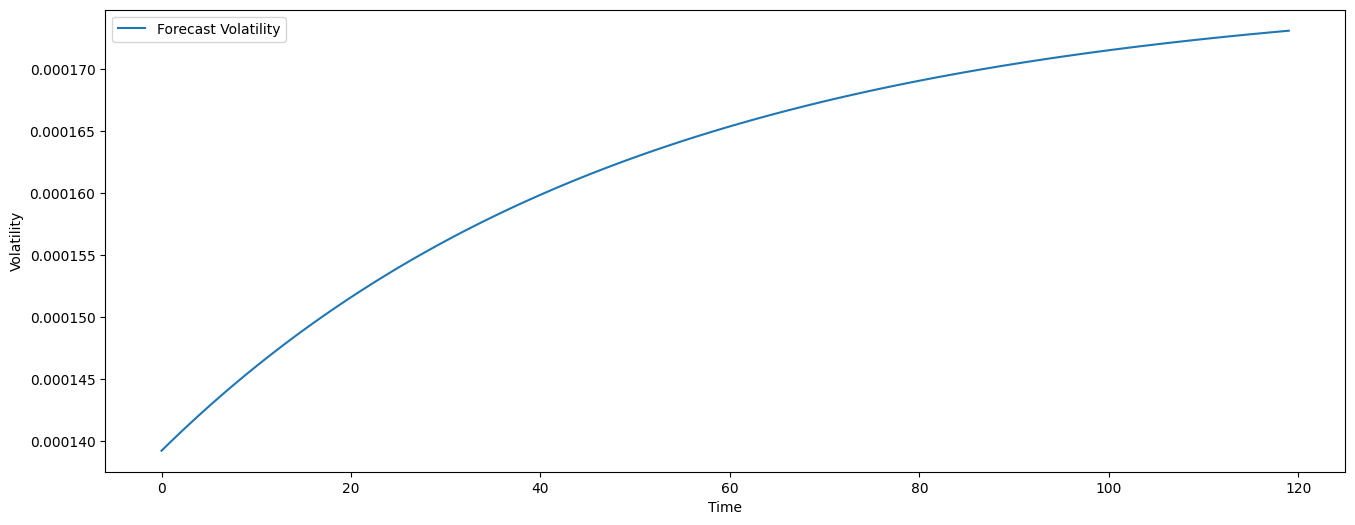

In [15]:
forecast = forecast_model_fit.forecast(horizon=120,method='analytic')
volf = forecast.variance.values.flatten()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(volf, label="Forecast Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [16]:
volf

array([0.00013921, 0.00013996, 0.00014069, 0.0001414 , 0.0001421 ,
       0.00014279, 0.00014346, 0.00014412, 0.00014477, 0.0001454 ,
       0.00014602, 0.00014663, 0.00014723, 0.00014781, 0.00014839,
       0.00014895, 0.0001495 , 0.00015004, 0.00015056, 0.00015108,
       0.00015159, 0.00015209, 0.00015257, 0.00015305, 0.00015352,
       0.00015398, 0.00015443, 0.00015487, 0.0001553 , 0.00015572,
       0.00015614, 0.00015654, 0.00015694, 0.00015733, 0.00015771,
       0.00015809, 0.00015845, 0.00015881, 0.00015917, 0.00015951,
       0.00015985, 0.00016018, 0.00016051, 0.00016083, 0.00016114,
       0.00016144, 0.00016174, 0.00016204, 0.00016233, 0.00016261,
       0.00016289, 0.00016316, 0.00016342, 0.00016368, 0.00016394,
       0.00016419, 0.00016443, 0.00016467, 0.00016491, 0.00016514,
       0.00016537, 0.00016559, 0.0001658 , 0.00016602, 0.00016623,
       0.00016643, 0.00016663, 0.00016683, 0.00016702, 0.00016721,
       0.00016739, 0.00016757, 0.00016775, 0.00016792, 0.00016